In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from optuna.samplers import TPESampler
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import shap

# Define specific time points for interpolation
interp_time_points = [1, 2, 3]
num_interp_pts = len(interp_time_points)
n_outer_folds = 10
n_inner_folds = 2
n_trials = 50
# ----------------------------------------------------------------------------------------
# Load data
# ----------------------------------------------------------------------------------------
file_path_form = 'mp_dataset_processed_no_dupes.xlsx'
file_path_time = 'mp_dataset_processed_time_release_only.xlsx'
formulation_df = pd.read_excel(file_path_form, engine='openpyxl')
release_df = pd.read_excel(file_path_time, engine='openpyxl')
# Encode categorical
unique_values_emulsion = formulation_df['Formulation Method'].unique()
mapping = {v: i for i, v in enumerate(unique_values_emulsion)}
formulation_df['Formulation Method Encoded'] = formulation_df['Formulation Method'].map(mapping)
formulation_df.drop(columns=['Formulation Method', 'Drug SMILES'], inplace=True)
# ----------------------
# Interpolation at specific time points (1, 2, 3)
# ----------------------
interpolated_dfs = []
for formulation, g in release_df.groupby('Formulation Index'):
    g = g.sort_values('Time')
    # Interpolate at fixed time points
    interp_release = np.interp(interp_time_points, g['Time'], g['Release'])
    interpolated_dfs.append(pd.DataFrame({
        'Formulation Index': formulation,
        'Time_interp': interp_time_points,
        'Interpolated Release': interp_release
    }))
interp_df = pd.concat(interpolated_dfs, ignore_index=True)

In [21]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.multioutput import MultiOutputRegressor

# ----------------------------------------------------------------------------------------
# Prepare X and y
# ----------------------------------------------------------------------------------------
X = formulation_df.drop(columns=['Formulation Index']).to_numpy()
y = interp_df.pivot(index='Formulation Index', columns='Time_interp', values='Interpolated Release').to_numpy()

# ----------------------------------------------------------------------------------------
# Model wrapper for Linear Regression
# ----------------------------------------------------------------------------------------
class LinearModel:
    def __init__(self):
        self.model = LinearRegression()
    
    def fit(self, X, y):
        self.model.fit(X, y)
    
    def predict(self, X):
        return self.model.predict(X)
    
    def evaluate(self, X, y_true):
        y_pred = self.predict(X)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        return rmse

# ----------------------------------------------------------------------------------------
# CV setup (only outer CV needed - no hyperparameters to tune)
# ----------------------------------------------------------------------------------------
outer_kf = KFold(n_splits=n_outer_folds, shuffle=True, random_state=42)

# ----------------------------------------------------------------------------------------
# Storage
# ----------------------------------------------------------------------------------------
stored_best_models = []
stored_best_preds = []
stored_test_targets = []
stored_best_rmse = []
stored_best_mse = []
stored_corr = []
stored_pval = []
stored_shap_values = []
stored_shap_test_sets = []

# ----------------------------------------------------------------------------------------
# Outer CV loop
# ----------------------------------------------------------------------------------------
for outer_fold, (train_idx, test_idx) in enumerate(outer_kf.split(X, y)):
    print(f"\nOuter Fold {outer_fold + 1}")
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    stored_test_targets.append(y_test)

    # ----------------------------------------------------------------------------------------
    # Train model (no tuning needed)
    # ----------------------------------------------------------------------------------------
    model = LinearModel()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # ----------------------------------------------------------------------------------------
    # SHAP values
    # ----------------------------------------------------------------------------------------
    print("Calculating SHAP values...")
    explainer = shap.LinearExplainer(model.model, X_train)
    shap_values = explainer.shap_values(X_test)  # Shape: (n_samples, n_features, n_outputs)
    stored_shap_values.append(shap_values)
    stored_shap_test_sets.append(X_test)

    # ----------------------------------------------------------------------------------------
    # Compute metrics
    # ----------------------------------------------------------------------------------------
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    corr, pval = pearsonr(y_test.flatten(), preds.flatten())

    # Per-timepoint metrics
    for i, t in enumerate(interp_time_points):
        rmse_t = np.sqrt(mean_squared_error(y_test[:, i], preds[:, i]))
        corr_t, _ = pearsonr(y_test[:, i], preds[:, i])
        print(f"  Time {t}h: RMSE={rmse_t:.4f}, Corr={corr_t:.4f}")

    # ----------------------------------------------------------------------------------------
    # Store results
    # ----------------------------------------------------------------------------------------
    stored_best_models.append(model)
    stored_best_preds.append(preds)
    stored_best_mse.append(mse)
    stored_best_rmse.append(rmse)
    stored_corr.append(corr)
    stored_pval.append(pval)

    print(f"Fold {outer_fold+1} Overall - RMSE: {rmse:.4f}, Corr: {corr:.4f}, p-val: {pval:.2e}")

# ----------------------------------------------------------------------------------------
# Summary
# ----------------------------------------------------------------------------------------
print("\n" + "="*60)
print("LINEAR REGRESSION SUMMARY")
print("="*60)
print(f"Mean RMSE: {np.mean(stored_best_rmse):.4f} ± {np.std(stored_best_rmse):.4f}")
print(f"Mean Corr: {np.mean(stored_corr):.4f} ± {np.std(stored_corr):.4f}")


Outer Fold 1
Calculating SHAP values...
  Time 24h: RMSE=0.1932, Corr=0.2660
  Time 48h: RMSE=0.2204, Corr=0.3063
  Time 72h: RMSE=0.2367, Corr=0.3368
Fold 1 Overall - RMSE: 0.2175, Corr: 0.3665, p-val: 1.91e-04

Outer Fold 2
Calculating SHAP values...
  Time 24h: RMSE=0.1379, Corr=0.4581
  Time 48h: RMSE=0.1825, Corr=0.4302
  Time 72h: RMSE=0.2096, Corr=0.4243
Fold 2 Overall - RMSE: 0.1791, Corr: 0.4894, p-val: 4.18e-07

Outer Fold 3
Calculating SHAP values...
  Time 24h: RMSE=0.2045, Corr=0.2216
  Time 48h: RMSE=0.2217, Corr=0.2687
  Time 72h: RMSE=0.2399, Corr=0.3246
Fold 3 Overall - RMSE: 0.2225, Corr: 0.3703, p-val: 2.05e-04

Outer Fold 4
Calculating SHAP values...
  Time 24h: RMSE=0.1812, Corr=0.2274
  Time 48h: RMSE=0.2012, Corr=0.2619
  Time 72h: RMSE=0.2064, Corr=0.3329
Fold 4 Overall - RMSE: 0.1966, Corr: 0.3529, p-val: 4.20e-04

Outer Fold 5
Calculating SHAP values...
  Time 24h: RMSE=0.1916, Corr=0.4476
  Time 48h: RMSE=0.2162, Corr=0.3963
  Time 72h: RMSE=0.2180, Corr=0.4

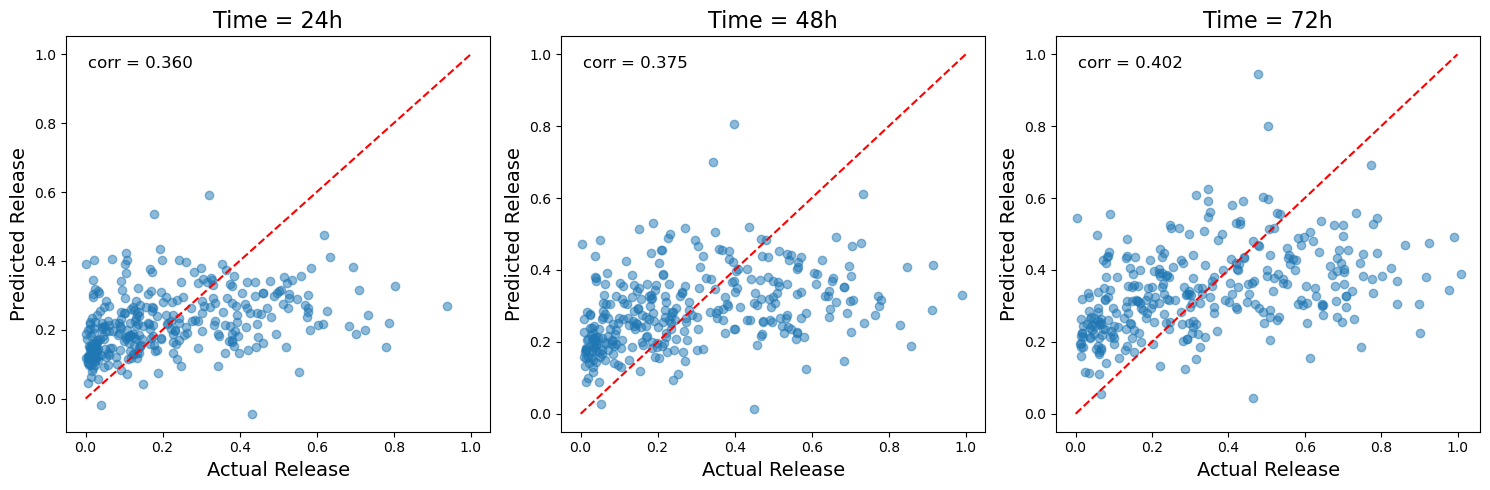

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
all_preds = np.vstack(stored_best_preds)
all_targets = np.vstack(stored_test_targets)

for i, t in enumerate(interp_time_points):
    ax = axes[i]
    ax.scatter(all_targets[:, i], all_preds[:, i], alpha=0.5)
    ax.plot([0, 1], [0, 1], 'r--', label='Ideal')
    ax.set_xlabel("Actual Release", fontsize=14)
    ax.set_ylabel("Predicted Release", fontsize=14)
    ax.set_title(f"Time = {t}h", fontsize=16)  # Just use t directly
    corr, _ = pearsonr(all_targets[:, i], all_preds[:, i])
    ax.text(0.05, 0.95, f"corr = {corr:.3f}", transform=ax.transAxes, fontsize=12, va='top')
plt.tight_layout()
plt.show()

In [20]:
# Storage per timepoint
rmse_per_timepoint = {t: [] for t in interp_time_points}
corr_per_timepoint = {t: [] for t in interp_time_points}
pval_per_timepoint = {t: [] for t in interp_time_points}  # NEW
p = X.shape[1]

for preds, targets in zip(stored_best_preds, stored_test_targets):
    n = len(targets)
    for i, t in enumerate(interp_time_points):
        rmse_t = np.sqrt(mean_squared_error(targets[:, i], preds[:, i]))
        rmse_per_timepoint[t].append(rmse_t)
        
        corr_t, pval_t = pearsonr(targets[:, i], preds[:, i])  # capture p-value
        corr_per_timepoint[t].append(corr_t)
        pval_per_timepoint[t].append(pval_t)  # NEW

# Print summary
print(f"{'Time':<10} {'RMSE':<20} {'Correlation (p-val)':<25}")
print("=" * 75)
for t in interp_time_points:
    rmse_mean, rmse_std = np.mean(rmse_per_timepoint[t]), np.std(rmse_per_timepoint[t])
    corr_mean = np.mean(corr_per_timepoint[t])
    pval_mean = np.mean(pval_per_timepoint[t])  # or use median for p-values
    print(f"{t}h{'':<8} {rmse_mean:.4f} ± {rmse_std:.4f}    {corr_mean:.4f} (p={pval_mean:.2e})")

Time       RMSE                 Correlation (p-val)      
24h         0.1817 ± 0.0242    0.3888 (p=9.23e-02)
48h         0.2097 ± 0.0245    0.3933 (p=6.84e-02)
72h         0.2242 ± 0.0245    0.4162 (p=3.80e-02)
